In [1]:
# initialize inline plotting and load the usual suspects
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
from scipy import signal

# Designing an IIR Filter from a CT Prototype

This notebook performs the computtional steps to convert a good analog filter into a digital filter. Both the *impulse invariance* method and the *bilinear transformation* are shown.

The notebook relies on some of the functions in the [SciPy `signals` package](https://docs.scipy.org/doc/scipy/reference/signal.html). Equivalent functions exist in the [Matlab Signal Processing Toolbox](https://www.mathworks.com/help/signal/ug/iir-filter-design.html).

The running example is a 4-th order Butterworth filter - since the pole locations have very simple expressions - with 3dB corner frequency $\Omega_c=\pi/4$. Note, that this frequency is a valid DT frequency $\omega_c$, hence, below we set the sampling period $T_d$ that connects CT and DT freqeuncies ($\omega_c = \Omega_c T_d$) to $T_d=1$.

In [2]:
# parameters of 4th-order Butterworth filter
fc = 1/8
wc = 2*np.pi*fc
N = 4

# the butterworth filter has poles on a circle of radius Omega_c
poles = wc*np.exp(1j*np.arange(5, 12, 2)*np.pi/8)

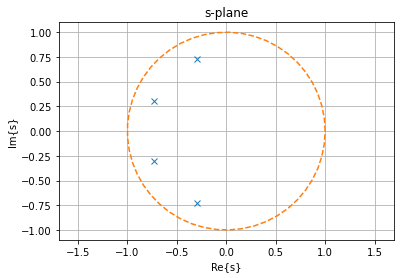

In [3]:
#plot the pole locations - n.b. this is the s-plane!!!
plt.plot(poles.real, poles.imag, 'x')
plt.plot(np.cos(np.linspace(0, 2*np.pi)), np.sin(np.linspace(0,2*np.pi)),'--')
plt.axis('equal')
plt.xlabel('Re{s}')
plt.ylabel('Im{s}')
plt.title('s-plane')
plt.grid()
plt.show()

From the zero and pole locations, we can compute the frequency response
$$
H(j\Omega) = k \cdot \prod_{k=1}^N \frac{1}{j\Omega - s_k} 
$$
where $k = \prod s_k = \Omega_c^4$ is a scaling constant to ensure that $H(0)=1$.

The function `zpk2tf` converts zeros and poles to the coefficients of numerator and denominator polynomials of the transfer function and the function `freqs` compute the contnuous-time transfer function.

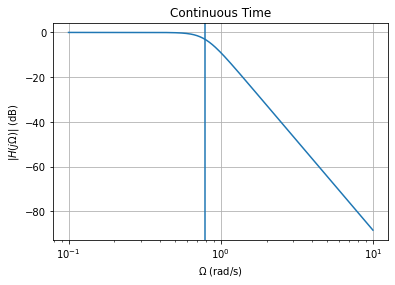

In [4]:
# CT Frequency Response

b, a = signal.zpk2tf([],poles, wc**4)

w,h = signal.freqs(b, a)
plt.semilogx(w, 20*np.log10(abs(h)))
plt.xlabel('$\Omega$ (rad/s)')
plt.ylabel('$|H(j\Omega)|$ (dB)')
plt.title('Continuous Time')
plt.grid()
plt.axvline(wc)
plt.show()

## Impulse Invariance Method

The impulse invariance method relies on sampling the continuous-time impulse repsonse. We will see that we don't actually need to compute this impulse response but for illustration we will find it along the way.

In any event, we need to perform a partial fraction expansion of the system function $H(s)$. The following function performs PFE given zeros and poles of the system function. 

Note: the toolbox function `residue` could have been used for this purpose.

In [5]:
def pfe_zpk_s(poles, zeros=[], scale=1):
    '''Partial fraction expansion
    
    Given a set of distinct poles, find the coefficients of the partial fraction expansion
    
    Limitations:
     * all poles must be distinct
     * number of zeros can be at most equal to number of poles
     
    Returns:
    Ak - array of coefficients in partial fraction expansion
    k - constant term in PFE; is [] when number of zeros is less than number of poles
    '''
    A = scale*np.ones(np.shape(poles), dtype=np.complex)
    if len(poles) == len(zeros):
        k = scale
    else:
        k = []
    
    for n in range(len(poles)):
        this_pole = poles[n]
        
        for m in range(len(zeros)):
            A[n] *= (this_pole - zeros[m])
            
        for m in range(len(poles)):
            if m != n:
                A[n] /= (this_pole - poles[m])
    return A, k

In [6]:
# unit tests: 1/((s-2)*(s-4)) = -0.5/(s-2) + 0.5/(s-4)
c, k = pfe_zpk_s(np.array([2, 4]), [], 1)

assert np.all(c == np.array([-0.5, 0.5], dtype=np.complex))
assert k == []

# 1/(s^2 + 1) = -0.5j/(s-j) + 0.5j/(s+j)
c, k = pfe_zpk_s(np.array([1j, -1j]), [], 1)

assert np.all(c == np.array([-0.5j, 0.5j], dtype=np.complex))
assert k == []

With this function, we can easily find the coefficients $A_k$ of the PFE
$$
    H(s) = k \cdot \sum_{k=1}^N \frac{A_k}{s-s_k} + k_c\delta(t).
$$
Note that the constant term $k_c$ is zero because the order of the numerator polynomial is smaller than that of the denominator polynomial; put differntly, there are fewer zeros (0) than poles (4).

We display them in polar form.

In [7]:
# coefficients for CT PFE
A, kc = pfe_zpk_s(poles, [])

A, abs(A), np.angle(A)/np.pi,  kc

(array([-0.95348904+0.39494809j,  0.95348904-2.30192618j,
         0.95348904+2.30192618j, -0.95348904-0.39494809j]),
 array([1.0320491 , 2.49158694, 2.49158694, 1.0320491 ]),
 array([ 0.875, -0.375,  0.375, -0.875]),
 [])

In [8]:
# alternatively, we could have used residue and zpk2tf as foolows:
A, _, kc = signal.residue(*signal.zpk2tf([], poles, 1))

A, kc

(array([ 0.95348904+2.30192618j,  0.95348904-2.30192618j,
        -0.95348904+0.39494809j, -0.95348904-0.39494809j]),
 array([], dtype=float64))

The CT impulse response $h_c(t)$ is now easily found. Each of the terms in the PFE yields an exponential signal, so that
$$
    h_c(t) = k \cdot \sum_{k=1}^N A_k \cdot e^{s_kt} \cdot u(t).
$$

The impulse response is plotted below.

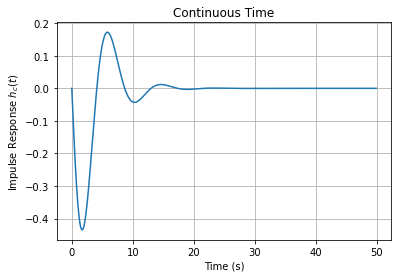

In [9]:
# continuous time impulse response
tt = np.arange(500)*0.1
hc = np.zeros_like(tt, dtype=np.complex)

for k in range(len(poles)):
    hc += wc**4 * A[k]*np.exp(poles[k]*tt)
    
plt.plot(tt, hc.real)
plt.ylabel('Impulse Response $h_c(t)$')
plt.xlabel('Time (s)')
plt.title('Continuous Time')
plt.grid()
plt.show()

The above impulse response could be sampled and the samples could be used to design an FIR filter. However, a much shorter IIR filter can be found because the impulse response is a sum of exponentials.

For impulse invariance, the discrete-time impulse response $h[n]$ follows from $h_c(t)$ via
$$
 h[n] = T_d \cdot h_c(nT_d) = k \cdot \sum_{k=1}^N A_k (e^{s_kT_d})^n \cdot u[n]
$$

The key insight is that this impulse response has a z-transform:
$$
  H(z) = k \cdot \sum_{k=1}^N \frac{A_k}{1-(e^{s_kT_d})z^{-1}}
$$
so that the poles of the digital filter in the z-plane are at location
$$
    d_k = e^{s_kT_d}.
$$
This is the key insight in the design of digital filters via impulse invariance.

Quick note regarding $T_d$: this parameter is selected so that $\Omega_c T_d$ equals the desired digital corner frequency $omega_c$. Since we set $\Omega_c=\pi/4$, we use $T_d=1$ here.

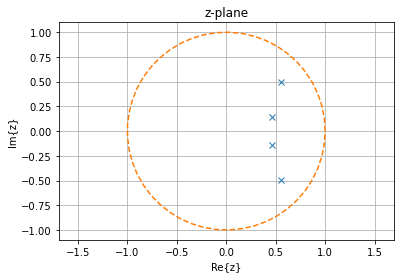

In [10]:
# discrete-time poles
d = np.exp(poles)

plt.plot(d.real, d.imag, 'x')
plt.plot(np.cos(np.linspace(0, 2*np.pi)), np.sin(np.linspace(0,2*np.pi)),'--')
plt.axis('equal')
plt.xlabel('Re{z}')
plt.ylabel('Im{z}')
plt.title('z-plane')
plt.grid()
plt.show()

For completenes, we plot the discrete-time frequency response - which is just a sampled version of $h_c(t)$. Again, the impulse response is not needed for the design.

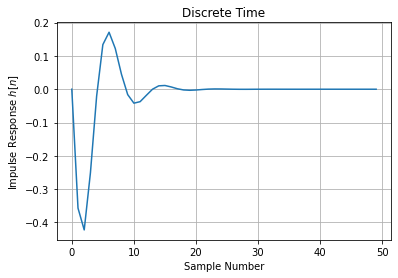

In [11]:
# discrete time impulse response
nn = np.arange(50)
hh = np.zeros_like(nn, dtype=np.complex)

for k in range(len(d)):
    hh += wc**4 * A[k] * (d[k]**nn)

plt.plot(nn, hh.real)
plt.ylabel('Impulse Response $h[n]$')
plt.xlabel('Sample Number')
plt.title('Discrete Time')
plt.grid()
plt.show()

More interestingly, the frequency response of our IIR filter can be computed (using function `zpk2tf` and `freqz`).

The frequency response matches the CT frequency response closely. The frequency axis should not be scaled logarithmically (this is done only for comparison with the analog function). The difference near $\omega=\pi$ is due to aliasing.

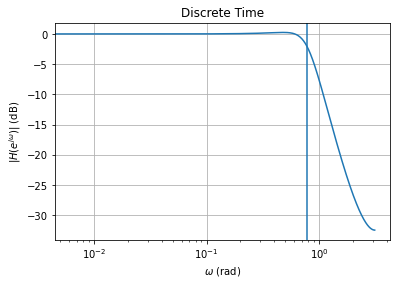

In [12]:
# discrete time frequency response
# Note: we know that a Butterworth filter shouldn't have zeros - need to be more careful
# with filters that have zeros (see below)
b, a = signal.zpk2tf([], d, np.real(np.prod(1-d)))

w,h = signal.freqz(b, a)
plt.semilogx(w, 20*np.log10(abs(h)))
plt.xlabel('$\omega$ (rad)')
plt.ylabel('$|H(e^{j\omega})|$ (dB)')
plt.title('Discrete Time')
plt.grid()
plt.axvline(wc)
plt.show()

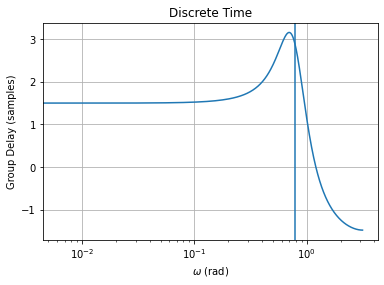

In [13]:
# group delay
w, gd = signal.group_delay((b, a), w)
plt.semilogx(w, gd)
plt.xlabel('$\omega$ (rad)')
plt.ylabel('Group Delay (samples)')
plt.title('Discrete Time')

plt.grid()
plt.axvline(wc)
plt.show()

Below are the coeeficients of the numerator and denominator of $H(z)$

In [14]:
a.real, b.real

(array([ 1.        , -2.03244045,  1.8068013 , -0.76643065,  0.12843346]),
 array([0.13636366]))

## Bilinear Transformation

An alternative method for converting an analog prototype filter to a digital filter is the *bilinear transform*.
This transform is a mapping that maps the left half of the s-plane onto the disc inside the unit circle of the z-plane. The imaginary axis is mapped onto the unit circle.

The transformation is defined by
$$
    s = \frac{2}{T_d} \frac{1-z^{-1}}{1+z^{-1}}
$$
and the design method simply inserts the above apping in the CT system function $H(s)$.

This mapping has the effect that poles $s_k$ are mapped to 
$$
    d_k = \frac{2+s_k}{2-s_k}.
$$
Additionally, this mapping creates $N$ zeros at $c_k=-1$.

Note: there exists a function `bilinear_zpk` to map analog zeros and poles to digital zeros and poles.

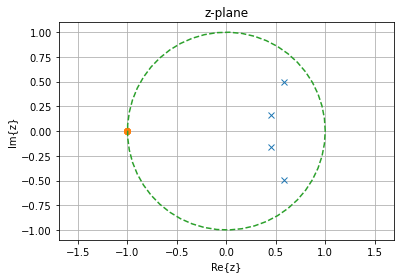

In [15]:
# Bilinear transformation
#[cb, db, kb] = signal.bilinear_zpk([], poles, wc**4, 1)

cp = -1*np.ones(4)
dp = (2+poles)/(2-poles)
kp = np.prod((1-dp)/2)

plt.plot(dp.real, dp.imag, 'x')
plt.plot(cp.real, cp.imag, 'o')
plt.plot(np.cos(np.linspace(0, 2*np.pi)), np.sin(np.linspace(0,2*np.pi)),'--')
plt.xlabel('Re{z}')
plt.ylabel('Im{z}')
plt.title('z-plane')

plt.axis('equal')
plt.grid()
plt.show()


With the zeros and poles found, we can again find the frequency response of the filter.

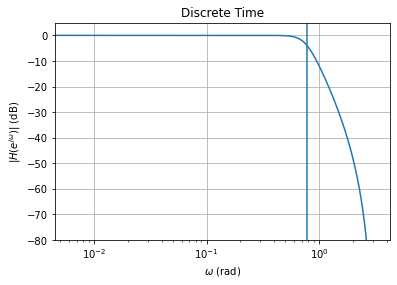

In [16]:
# discrete time frequency response
b, a = signal.zpk2tf(cp, dp, kp)

w,h = signal.freqz(b, a)
plt.semilogx(w, 20*np.log10(abs(h)))
plt.xlabel('$\omega$ (rad)')
plt.ylabel('$|H(e^{j\omega})|$ (dB)')
plt.title('Discrete Time')

plt.ylim([-80, 5])
plt.grid()
plt.axvline(wc)
plt.show()

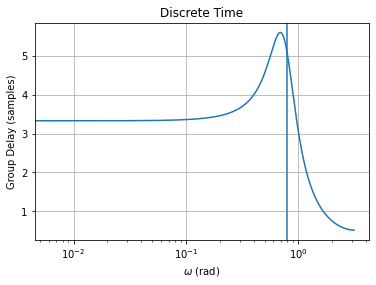

In [17]:
# group delay
w, gd = signal.group_delay((b, a), w)
plt.semilogx(w, gd)
plt.xlabel('$\omega$ (rad)')
plt.ylabel('Group Delay (samples)')
plt.title('Discrete Time')

plt.grid()
plt.axvline(wc)
plt.show()

## Using Toolbox functions

The Scipy `signal` package contains functions that provide the zeros and poles for analog filters. Additional, there are functions for converting from zeros and poles to transfer functions as well as for computing the frequency response.

The code below illustrates how these functions may be used to design filters with given order, passband edge, and passband or stopband ripples. Note that not all filters allow specifications of all of these parameters.

### Analog Prototype

zeros:  [] 
poles:  [-0.06689267+0.74336714j -0.1614932 +0.30791275j -0.1614932 -0.30791275j
 -0.06689267-0.74336714j] 
scale:  0.04767610399657924


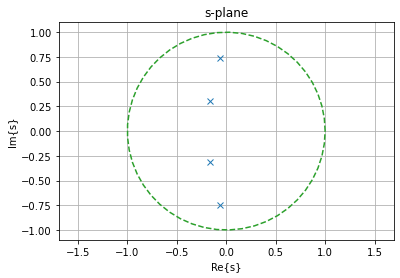

In [18]:
## CT prototype filter (try `cheby1`, cheby2` or `ellip` instead - they have slightly different syntax)

#parameters
N = 4       # filter order
wc = np.pi/4   # passband edge
rp = 3      # passband ripple
rs = 40     # stopband attenuation (ripple)

Td = 1.     # sampling interval

## Uncomment one of the following four lines
#[z,p,k] = signal.butter(N, wc, 'lowpass', analog=True, output='zpk')
[z,p,k] = signal.cheby1(N, rp, wc, 'lowpass', analog=True, output='zpk')
#[z,p,k] = signal.cheby2(N, rs, wc, 'lowpass', analog=True, output='zpk')
#[z,p,k] = signal.ellip(N, rp, rs, wc, 'lowpass', analog=True, output='zpk')


print('zeros: ', z, '\npoles: ', p, '\nscale: ', k)

plt.plot(p.real, p.imag, 'x')
plt.plot(z.real, z.imag, 'o')
plt.plot(np.cos(np.linspace(0, 2*np.pi)), np.sin(np.linspace(0,2*np.pi)),'--')
plt.axis('equal')
plt.xlabel('Re{s}')
plt.ylabel('Im{s}')
plt.title('s-plane')
plt.grid()
plt.show()

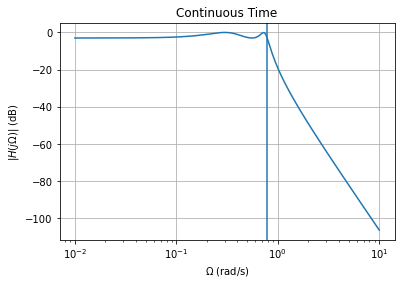

In [19]:
## CT frequency response
b, a = signal.zpk2tf(z,p,k)

w,h = signal.freqs(b, a)
plt.semilogx(w, 20*np.log10(abs(h)))
plt.xlabel('$\Omega$ (rad/s)')
plt.ylabel('$|H(j\Omega)|$ (dB)')
plt.title('Continuous Time')
plt.grid()
plt.axvline(wc)
plt.show()

### Convert to DT - using bilinear transform

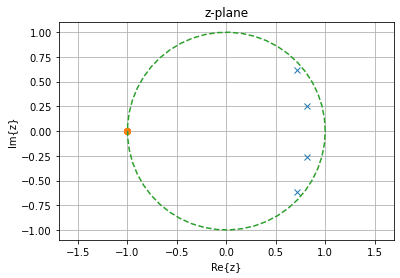

In [20]:
# Convert to DT - using bilinear transforms
zd, pd, kd = signal.bilinear_zpk(z, p, k, 1/Td)

plt.plot(pd.real, pd.imag, 'x')
plt.plot(zd.real, zd.imag, 'o')
plt.plot(np.cos(np.linspace(0, 2*np.pi)), np.sin(np.linspace(0,2*np.pi)),'--')
plt.xlabel('Re{z}')
plt.ylabel('Im{z}')
plt.title('z-plane')

plt.axis('equal')
plt.grid()
plt.show()

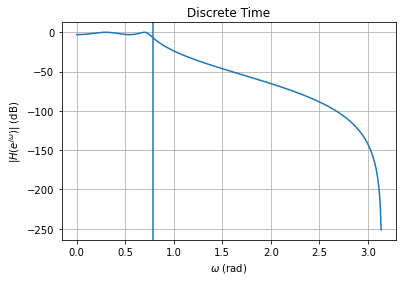

In [21]:
# Frequency response
b, a = signal.zpk2tf(zd, pd, kd)

w,h = signal.freqz(b, a)
plt.plot(w, 20*np.log10(abs(h)))
plt.xlabel('$\omega$ (rad)')
plt.ylabel('$|H(e^{j\omega})|$ (dB)')
plt.title('Discrete Time')

plt.grid()
plt.axvline(wc)
plt.show()

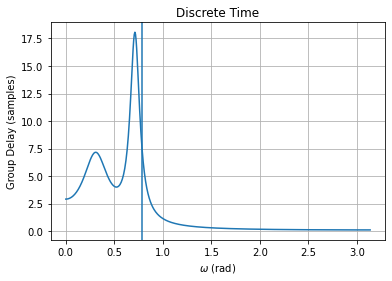

In [22]:
# group delay
w, gd = signal.group_delay((b, a), w)
plt.plot(w, gd)
plt.xlabel('$\omega$ (rad)')
plt.ylabel('Group Delay (samples)')
plt.title('Discrete Time')

plt.grid()
plt.axvline(wc)
plt.show()

In [23]:
# show filter coefficents
print('b: ', b, '\na: ', a)

b:  [0.00207302 0.00829207 0.01243811 0.00829207 0.00207302] 
a:  [ 1.         -3.05475939  3.94091359 -2.48741977  0.64811703]


### Convert to DT - using Impulse Invariance

The SciPy `signal` package does not include a method for doing this directly. However, it is not very hard to perform this conversion using the following sequence of steps:

* given CT zeros and poles, perform a partial fraction expansion
* map the CT poles `sk` to DT poles `dk` using $d_k = \exp(s_k T_d)$
* Combine the partial fractions into numerator and denominator polynomials of $H(z)$; this allows us to find the zeros of $H(z)$ and the coefficients of the filter. 

For the last step, we need the function `invpfe_z` (further below) or use the toolbox function `invres_z` to combine the terms of the partial fraction expansion into numerator and denominator polynomials.

Note: if the analog filter does not have zeros (i.e., Butterworth and Chebyshev Type I) then the digital filter won't have zeros either. In that case, we can avoid numerical problems by bypassing the last step and forcing the filter to have no zeros.

In [24]:
# Convert CT zeros, poles into polynomials
b, a = signal.zpk2tf(z, p, k)

# partial fraction expansion in CT
Ak, sk, kc = signal.residue(b, a)

# map CT poles to DT poles
dkt = np.exp(sk*Td)

if len(z) > 0:
    # Filter has zeros
    # combine partial fractions in DT
    b, a = signal.invresz(Ak, dkt, kc)

    # find zeros and poles of DT system
    ck, dk, k = signal.tf2zpk(b, a)
else:
    # Filter has no zeros - force that to be true
    ck = np.array([], dtype=np.complex)
    dk = dkt
    k = np.prod(1-dk)
    
    b, a = signal.zpk2tf(ck, dk, k)

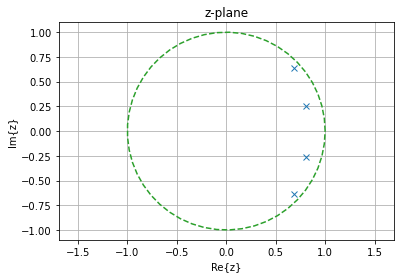

In [25]:
# plot zeros and poles
plt.plot(dk.real, dk.imag, 'x')
plt.plot(ck.real, ck.imag, 'o')
plt.plot(np.cos(np.linspace(0, 2*np.pi)), np.sin(np.linspace(0,2*np.pi)),'--')
plt.xlabel('Re{z}')
plt.ylabel('Im{z}')
plt.title('z-plane')

plt.axis('equal')
plt.grid()
plt.show()

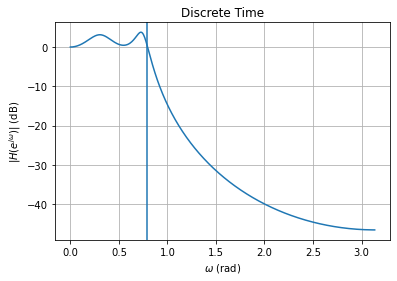

In [26]:
w,h = signal.freqz(b, a)
plt.plot(w, 20*np.log10(abs(h)))
plt.xlabel('$\omega$ (rad)')
plt.ylabel('$|H(e^{j\omega})|$ (dB)')
plt.title('Discrete Time')

plt.grid()
plt.axvline(wc)
plt.show()

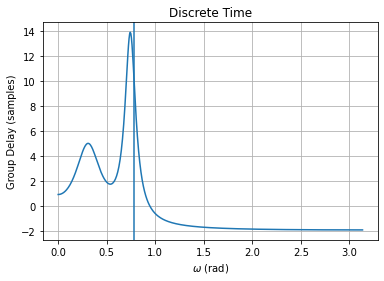

In [27]:
# group delay
w, gd = signal.group_delay((b, a), w)
plt.plot(w, gd)
plt.xlabel('$\omega$ (rad)')
plt.ylabel('Group Delay (samples)')
plt.title('Discrete Time')

plt.grid()
plt.axvline(wc)
plt.show()

In [28]:
# show filter coefficents
print('b: ', b.real, '\na: ', a.real)

b:  [0.05089823] 
a:  [ 1.         -2.99882647  3.83204542 -2.41564559  0.63332488]


In [29]:
def invpfe_z(Ak, dk, kc):
    '''Inverse of partial fraction expansion
    
    Compute coefficients of numerator and denominator polynomials of H(z) = B(z)/A(z)
    '''
    # the denominator polynomial is prod_k (1-d_k*z^{-1}); we use convolution to
    # do the polynomial multiplication
    tmp = np.array([1], dtype=np.complex)
    for p in dk:
        tmp = signal.convolve(tmp, np.array([1, -p], dtype=np.complex))
    a = tmp
    M = len(a)-1   # order of denominator poly
    
    # the denominator polynomial has the form kc*A(z) + SUM_m Am * PROD_{k!=m} (1-dk*z^{-1})
    # when adding these polynomials, we must be careful with their length
    if len(kc) > 0:
        b = kc*a
        N = len(b)-1
    else:
        b = np.zeros(len(a)-1, dtype=np.complex)
        N = len(b) 
    
    for k in range(M):
        this_A = Ak[k]
        tmp = np.array([1], dtype=np.complex)
        for m in range(M):
            if k != m:
                # print(k, m, tmp)
                tmp = signal.convolve(tmp, np.array([1, -dk[m]], dtype=np.complex))
                # print(dk[m], tmp)
        # print(b, this_A, tmp)
        b[:N] += this_A * tmp
        
    return b, a

In [30]:
# unit test: 0.5/(1-j*z^{-1}) + 0.5/(1 + j*z^{-1}) = 1/(1-z^{-2})
b, a = invpfe_z(np.array([0.5, 0.5]), np.array([1j, -1j]), [])
assert np.all(b == np.array([1, 0], dtype=np.complex))
assert np.all(a == np.array([1, 0, 1], dtype=np.complex))

# compare to invresz
br, ar = signal.invresz(np.array([0.5, 0.5]), np.array([1j, -1j]), [])
assert np.all(a == ar)
assert np.all(b == br)